In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
#Creiamo un tf.data.Dataset a partire dalle immagini nella directory su disco per il training set e il test set.
train_set = tf.keras.preprocessing.image_dataset_from_directory(
    'train',
    labels='inferred',
    label_mode='int'
)

test_set = tf.keras.preprocessing.image_dataset_from_directory(
    'test',
    labels='inferred',
    label_mode='int'
)

Found 16932 files belonging to 4 classes.
Found 4233 files belonging to 4 classes.


In [3]:
#image_batch è un tensore della forma (32, 256, 256, 3) .
#Questo è un batch di 32 immagini di forma 256x256x3. 
#Il label_batch è un tensore della forma (32,4) cioè in ogni batch ci sono 32 immagini e le etichette sono 4
for image_batch, labels_batch in train_set:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 256, 256, 3)
(32,)


MobileNet deve ricevere come input immagini di dimensione (224,224,3), occorre dunque modificare la dimensione delle immagini. Inoltre i pixel devono assumere valori tra [-1, +1] e non da 0 a 255, occorre quindi anche eseguire una normalizzazione

In [4]:
#!pip install tensorflow --upgrade

In [5]:
from tensorflow.keras import layers

resize_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224, 224),
  layers.experimental.preprocessing.Rescaling(scale=1./127.5, offset=-1)

])

def prepare(ds):
    #Resize
    ds = ds.map(lambda x, y: (resize_rescale(x),y))
    return ds

train_set = prepare(train_set)
test_set = prepare(test_set)


In [6]:
#Verifichiamo che sia avvenuto il resizing 
for image_batch, labels_batch in train_set:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


# TRANSFER LEARNING 

In [7]:
#Creiamo il modello base considerando MobileNet, sviluppato da Google e pre-addestrato su ImageNet.
#Non consideriamo gli ultimi layer che sono finalizzati agli obiettivi di classificazione di Imagenet
base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet')

In [8]:
#Il base_model si comporta quindi come un estrattore di featues,
#In particolare estrae dalle immagini 224x224x3 in blocchi 7x7x1280 di features. 
image_batch, label_batch = next(iter(train_set))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [9]:
#Congeliamo il resto dei layer impedendone così l'aggiornamento durante l'addestramento.
base_model.trainable = False

In [10]:
#Ora a partire dal blocco di features, usiamo un layer tf.keras.layers.GlobalAveragePooling2D,
#facendo una media in una finestra 5x5, per generare le predizioni finali poichè ci consente di
#convertire le features in un singolo vettore di 1280 elementi per immagine.
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [11]:
#Definiamo uno strato fully-connected per convertire queste features in una singola predizione.
prediction_layer = tf.keras.layers.Dense(4, activation='relu')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [12]:
#Costruiamo il modello considerando quanto definito precedentemente
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [13]:
#Compiliamo il modello
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, None, None, 1280)  2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 5124      
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


In [14]:
#Addestriamo il modello sul train set
history = model.fit(train_set, epochs=5)

Epoch 1/5
530/530 [==============================] - 377s 705ms/step - loss: 0.5779 - accuracy: 0.7742
Epoch 2/5
530/530 [==============================] - 367s 692ms/step - loss: 0.4430 - accuracy: 0.8139
Epoch 3/5
530/530 [==============================] - 370s 694ms/step - loss: 0.4103 - accuracy: 0.8247
Epoch 4/5
530/530 [==============================] - 369s 692ms/step - loss: 0.3906 - accuracy: 0.8319
Epoch 5/5
530/530 [==============================] - 371s 695ms/step - loss: 0.3784 - accuracy: 0.8355


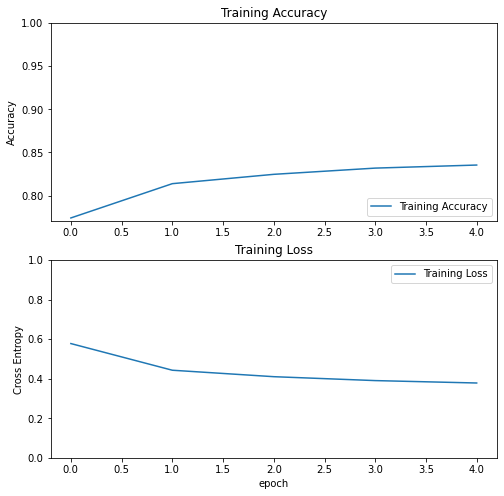

In [15]:
import matplotlib.pyplot as plt

#Analizziamo l'andamento dell'addestramento
acc = history.history['accuracy']
loss = history.history['loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()

In [16]:
#Valutiamo le prestazioni del modello sul test set
loss_test, accuracy_test = model.evaluate(test_set)
print('Test accuracy :', accuracy_test)

133/133 [==============================] - 94s 680ms/step - loss: 0.4074 - accuracy: 0.8209
Test accuracy : 0.8209307789802551


# FINE TUNING 

Un modo per incrementare le performance è eseguire fine-tuning, dove nel processo di training si 'aggiustano' i pesi degli ultimi layers così da specializzare la rete ancor di più al nostro dataset.

In [18]:
#'Scongeliamo' il base_model in modo da non addestrare solo i layer più in basso.
base_model.trainable = True

num_layers = len(base_model.layers)
num_layers

154

In [19]:
#Scegliamo di addestrare il modello solo a partire dal centesimo layer in su.
#quindi congeliamo tutti i layer precedenti.
finetune = 100
for layer in base_model.layers[:finetune]:
    layer.trainable =  False

In [20]:
#Ricompiliamo il modello.
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = 'adam',
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, None, None, 1280)  2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 5124      
Total params: 2,263,108
Trainable params: 1,866,564
Non-trainable params: 396,544
_________________________________________________________________


In [21]:
#Continuiamo con l'addestramento.
finetune_epochs = 5
total_epochs =  5 + finetune_epochs

history_fine = model.fit(train_set, epochs=total_epochs, initial_epoch=history.epoch[-1])
acc += history_fine.history['accuracy']
loss += history_fine.history['loss']

Epoch 5/10
530/530 [==============================] - 616s 1s/step - loss: 1.4592 - accuracy: 0.1752
Epoch 6/10
530/530 [==============================] - 574s 1s/step - loss: 1.3863 - accuracy: 0.1724
Epoch 7/10
530/530 [==============================] - 573s 1s/step - loss: 1.3863 - accuracy: 0.1724
Epoch 8/10
530/530 [==============================] - 574s 1s/step - loss: 1.3863 - accuracy: 0.1724
Epoch 9/10
530/530 [==============================] - 574s 1s/step - loss: 1.3863 - accuracy: 0.1724
Epoch 10/10
530/530 [==============================] - 570s 1s/step - loss: 1.3863 - accuracy: 0.1724


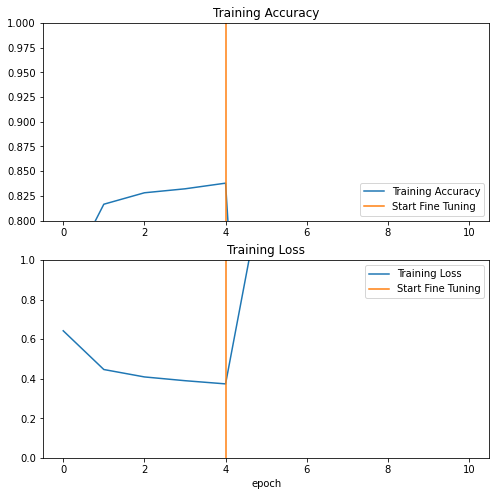

In [22]:
#Analizziamo l'andamento dell'addestramento.
initial_epochs = 5
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')

plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()


In [23]:
#Valutazione del modello sul test set.
loss_test_100, accuracy_test_100 = model.evaluate(test_set)
print('Test accuracy :', accuracy_test_100)

133/133 [==============================] - 95s 659ms/step - loss: 1.3863 - accuracy: 0.1647
Test accuracy : 0.16465863585472107


Si è verificato un estremo peggioramento in termini di accuracy. 
Eseguiamo ora il fine tuning mantenedo congelati solo fino all'ottantesimo layer e successivamente mantenendo congelati i primi 120 layer confrontando poi il comportamento della rete.  

FINE TUNING 'scongelando' strati a partire dall' 80

In [17]:
base_model.trainable = True

finetune_80 = 80
for layer in base_model.layers[:finetune_80]:
    layer.trainable =  False

In [18]:
#Ricompiliamo il modello.
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = 'adam',
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, None, None, 1280)  2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 5124      
Total params: 2,263,108
Trainable params: 2,043,908
Non-trainable params: 219,200
_________________________________________________________________


In [21]:
#Continuiamo con l'addestramento.
finetune_epochs = 5
total_epochs =  5 + finetune_epochs

history_fine_80 = model.fit(train_set, epochs=total_epochs, initial_epoch=history.epoch[-1])
acc += history_fine_80.history['accuracy']
loss += history_fine_80.history['loss']

Epoch 5/10
530/530 [==============================] - 646s 1s/step - loss: 1.3863 - accuracy: 0.1724
Epoch 6/10
530/530 [==============================] - 641s 1s/step - loss: 1.3863 - accuracy: 0.1724
Epoch 7/10
530/530 [==============================] - 636s 1s/step - loss: 1.3863 - accuracy: 0.1724
Epoch 8/10
530/530 [==============================] - 627s 1s/step - loss: 1.3863 - accuracy: 0.1724
Epoch 9/10
530/530 [==============================] - 627s 1s/step - loss: 1.3863 - accuracy: 0.1724
Epoch 10/10
530/530 [==============================] - 627s 1s/step - loss: 1.3863 - accuracy: 0.1724


In [22]:
#Valutazione del modello sul test set.
loss_test_80, accuracy_test_80 = model.evaluate(test_set)
print('Test accuracy :', accuracy_test_80)

133/133 [==============================] - 88s 635ms/step - loss: 1.3863 - accuracy: 0.1647
Test accuracy : 0.16465863585472107


FINE TUNING 'scongelando' strati a partire dal 120

In [17]:
base_model.trainable = True

finetune_120 = 120
for layer in base_model.layers[:finetune_120]:
    layer.trainable =  False

In [18]:
#Ricompiliamo il modello.
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = 'adam',
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, None, None, 1280)  2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 5124      
Total params: 2,263,108
Trainable params: 1,630,020
Non-trainable params: 633,088
_________________________________________________________________


In [19]:
#Continuiamo con l'addestramento.
finetune_epochs = 5
total_epochs =  5 + finetune_epochs

history_fine_120 = model.fit(train_set, epochs=total_epochs, initial_epoch=history.epoch[-1])
acc += history_fine_120.history['accuracy']
loss += history_fine_120.history['loss']

Epoch 5/10
530/530 [==============================] - 481s 895ms/step - loss: 1.4059 - accuracy: 0.1746
Epoch 6/10
530/530 [==============================] - 485s 906ms/step - loss: 1.3863 - accuracy: 0.1724
Epoch 7/10
530/530 [==============================] - 476s 893ms/step - loss: 1.3863 - accuracy: 0.1724
Epoch 8/10
530/530 [==============================] - 475s 890ms/step - loss: 1.3863 - accuracy: 0.1724
Epoch 9/10
530/530 [==============================] - 462s 867ms/step - loss: 1.3863 - accuracy: 0.1724
Epoch 10/10
530/530 [==============================] - 466s 874ms/step - loss: 1.3863 - accuracy: 0.1724


In [20]:
#Valutazione del modello sul test set.
loss_test_120, accuracy_test_120 = model.evaluate(test_set)
print('Test accuracy :', accuracy_test_120)

133/133 [==============================] - 89s 645ms/step - loss: 1.3863 - accuracy: 0.1647
Test accuracy : 0.16465863585472107
